Install & Import Required Libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


Load the Data

In [15]:
# Load datasets
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge labels with training features
train_data = train_features.merge(train_labels, on="respondent_id")

# Drop 'respondent_id' since it's not useful for prediction
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)


Handle Missing Values

In [16]:
# Separate numerical and categorical columns (excluding target variables)
num_cols = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"]).select_dtypes(include=['number']).columns
cat_cols = train_data.select_dtypes(include=['object']).columns

# Impute numerical columns with median
num_imputer = SimpleImputer(strategy="median")
train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])
test_features[num_cols] = num_imputer.transform(test_features[num_cols])

# Impute categorical columns with most frequent value
cat_imputer = SimpleImputer(strategy="most_frequent")
train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])
test_features[cat_cols] = cat_imputer.transform(test_features[cat_cols])  



Encode Categorical Variables

In [17]:
# Encode categorical columns using Label Encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_features[col] = le.transform(test_features[col])
    label_encoders[col] = le


Perform Exploratory Data Analysis (EDA)


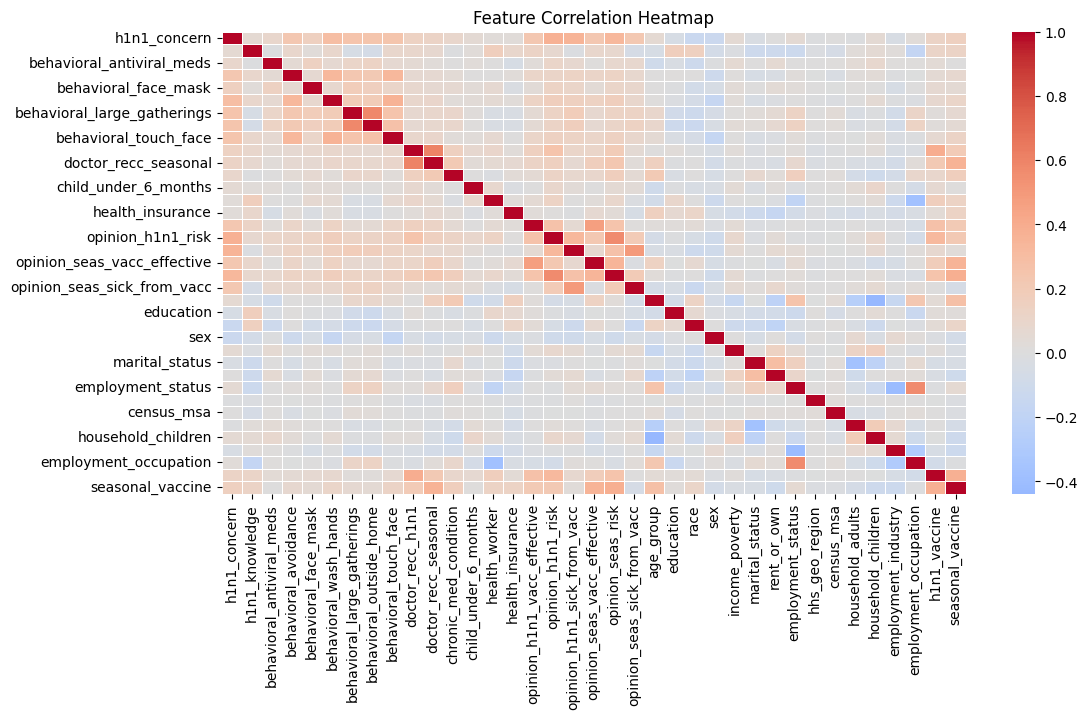

Top features influencing H1N1 Vaccine uptake:
 h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.394086
seasonal_vaccine               0.377143
opinion_h1n1_risk              0.320580
opinion_h1n1_vacc_effective    0.267352
opinion_seas_risk              0.255874
doctor_recc_seasonal           0.218976
opinion_seas_vacc_effective    0.177799
health_worker                  0.168056
h1n1_concern                   0.121574
Name: h1n1_vaccine, dtype: float64

Top features influencing Seasonal Flu Vaccine uptake:
 seasonal_vaccine               1.000000
opinion_seas_risk              0.386916
h1n1_vaccine                   0.377143
doctor_recc_seasonal           0.360696
opinion_seas_vacc_effective    0.358869
age_group                      0.277454
opinion_h1n1_risk              0.215650
opinion_h1n1_vacc_effective    0.203187
doctor_recc_h1n1               0.198560
chronic_med_condition          0.169465
Name: seasonal_vaccine, dtype: float64


In [18]:
# Correlation with target variables
corr_matrix = train_data.corr()

# Select top correlated features with target variables
top_corr_h1n1 = corr_matrix["h1n1_vaccine"].abs().sort_values(ascending=False)[:10]
top_corr_seasonal = corr_matrix["seasonal_vaccine"].abs().sort_values(ascending=False)[:10]

# Visualize correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Print top correlated features
print("Top features influencing H1N1 Vaccine uptake:\n", top_corr_h1n1)
print("\nTop features influencing Seasonal Flu Vaccine uptake:\n", top_corr_seasonal)


Split Data & Train a Model by Random Forest


In [19]:
# Define features (X) and target variables (y)
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Split data into training & validation sets
X_train, X_val, y_h1n1_train, y_h1n1_val = train_test_split(X, y_h1n1, test_size=0.2, random_state=42)
X_train, X_val, y_seasonal_train, y_seasonal_val = train_test_split(X, y_seasonal, test_size=0.2, random_state=42)

# Train RandomForest models
h1n1_model = RandomForestClassifier(n_estimators=100, random_state=42)
h1n1_model.fit(X_train, y_h1n1_train)

seasonal_model = RandomForestClassifier(n_estimators=100, random_state=42)
seasonal_model.fit(X_train, y_seasonal_train)

# Evaluate models
h1n1_preds = h1n1_model.predict(X_val)
seasonal_preds = seasonal_model.predict(X_val)

print("H1N1 Vaccine Model Accuracy:", accuracy_score(y_h1n1_val, h1n1_preds))
print("Seasonal Vaccine Model Accuracy:", accuracy_score(y_seasonal_val, seasonal_preds))


H1N1 Vaccine Model Accuracy: 0.8365780606514414
Seasonal Vaccine Model Accuracy: 0.7836016473231


For logistic regression

In [22]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load Dataset
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge Features with Labels
train_data = train_features.merge(train_labels, on="respondent_id")

# Drop Unnecessary Columns
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)

# Separate Features and Labels
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Identify Numeric and Categorical Columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Create Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Impute missing values with median
    ("scaler", StandardScaler())  # Scale numeric features
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Encode categorical features
])

# Combine Preprocessing Steps
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply Preprocessing
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_features)

# Split Data for Training and Validation
X_train, X_val, y_h1n1_train, y_h1n1_val = train_test_split(X_processed, y_h1n1, test_size=0.2, random_state=42)

# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_h1n1_train)

# Predict on Validation Set
y_pred = log_reg.predict(X_val)

# Evaluate Model
accuracy = accuracy_score(y_h1n1_val, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Make Predictions on Test Data
test_predictions = log_reg.predict(test_processed)

# Save Predictions to CSV
submission = pd.DataFrame({"h1n1_vaccine": test_predictions})
submission.to_csv("logistic_regression_predictions.csv", index=False)
print("Predictions saved to logistic_regression_predictions.csv")


Logistic Regression Accuracy: 0.8392
Predictions saved to logistic_regression_predictions.csv


for ANN,K-means,KNN 

In [26]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load Dataset
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge Features with Labels
train_data = train_features.merge(train_labels, on="respondent_id")

# Drop Unnecessary Columns
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)

# Separate Features and Labels
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Identify Numeric and Categorical Columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Create Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing numeric values
    ("scaler", StandardScaler())  # Scale numeric features
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical features
])

# Combine Preprocessing Steps
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply Preprocessing
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_features)

# Split Data for Training and Validation
X_train, X_val, y_h1n1_train, y_h1n1_val = train_test_split(X_processed, y_h1n1, test_size=0.2, random_state=42)
X_train_s, X_val_s, y_seasonal_train, y_seasonal_val = train_test_split(X_processed, y_seasonal, test_size=0.2, random_state=42)

# ----------------------------------------
# 🔹 Model: ANN (Artificial Neural Network)
# ----------------------------------------
ann_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
ann_model.fit(X_train, y_h1n1_train)
ann_model.fit(X_train_s, y_seasonal_train)

# Predict on Validation Set
y_pred_ann_h1n1 = ann_model.predict(X_val)
y_pred_ann_seasonal = ann_model.predict(X_val_s)

# Evaluate Model
accuracy_ann_h1n1 = accuracy_score(y_h1n1_val, y_pred_ann_h1n1)
accuracy_ann_seasonal = accuracy_score(y_seasonal_val, y_pred_ann_seasonal)

print(f"ANN H1N1 Vaccine Model Accuracy: {accuracy_ann_h1n1:.4f}")
print(f"ANN Seasonal Vaccine Model Accuracy: {accuracy_ann_seasonal:.4f}")

# Predict on Test Data
test_predictions_h1n1 = ann_model.predict(test_processed)
test_predictions_seasonal = ann_model.predict(test_processed)

# Save Predictions to CSV
pd.DataFrame({"h1n1_vaccine": test_predictions_h1n1}).to_csv("ann_predictions_h1n1.csv", index=False)
pd.DataFrame({"seasonal_vaccine": test_predictions_seasonal}).to_csv("ann_predictions_seasonal.csv", index=False)

print("Predictions saved to ann_predictions_h1n1.csv and ann_predictions_seasonal.csv")


ANN H1N1 Vaccine Model Accuracy: 0.5936
ANN Seasonal Vaccine Model Accuracy: 0.7042
Predictions saved to ann_predictions_h1n1.csv and ann_predictions_seasonal.csv


Logistic regression

In [29]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load Dataset
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge Features with Labels
train_data = train_features.merge(train_labels, on="respondent_id")

# Drop Unnecessary Columns
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)

# Separate Features and Labels
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Identify Numeric and Categorical Columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Create Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing numeric values
    ("scaler", StandardScaler())  # Scale numeric features
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical features
])

# Combine Preprocessing Steps
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply Preprocessing
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_features)

# Split Data for Training and Validation
X_train, X_val, y_h1n1_train, y_h1n1_val = train_test_split(X_processed, y_h1n1, test_size=0.2, random_state=42)
X_train_s, X_val_s, y_seasonal_train, y_seasonal_val = train_test_split(X_processed, y_seasonal, test_size=0.2, random_state=42)

# ----------------------------------------
# 🔹 Logistic Regression for H1N1 Vaccine
# ----------------------------------------
log_reg_h1n1 = LogisticRegression(max_iter=500)
log_reg_h1n1.fit(X_train, y_h1n1_train)

# Predict on Validation Set
y_pred_h1n1 = log_reg_h1n1.predict(X_val)

# Evaluate Model
accuracy_h1n1 = accuracy_score(y_h1n1_val, y_pred_h1n1)
print(f"Logistic Regression H1N1 Vaccine Model Accuracy: {accuracy_h1n1:.4f}")

# Predict on Test Data
test_predictions_h1n1 = log_reg_h1n1.predict(test_processed)

# Save Predictions to CSV
pd.DataFrame({"h1n1_vaccine": test_predictions_h1n1}).to_csv("logistic_regression_h1n1.csv", index=False)

# ----------------------------------------
# 🔹 Logistic Regression for Seasonal Vaccine
# ----------------------------------------
log_reg_seasonal = LogisticRegression(max_iter=500)
log_reg_seasonal.fit(X_train_s, y_seasonal_train)

# Predict on Validation Set
y_pred_seasonal = log_reg_seasonal.predict(X_val_s)

# Evaluate Model
accuracy_seasonal = accuracy_score(y_seasonal_val, y_pred_seasonal)
print(f"Logistic Regression Seasonal Vaccine Model Accuracy: {accuracy_seasonal:.4f}")

# Predict on Test Data
test_predictions_seasonal = log_reg_seasonal.predict(test_processed)

# Save Predictions to CSV
pd.DataFrame({"seasonal_vaccine": test_predictions_seasonal}).to_csv("logistic_regression_seasonal.csv", index=False)

print("Predictions saved to logistic_regression_h1n1.csv and logistic_regression_seasonal.csv")


Logistic Regression H1N1 Vaccine Model Accuracy: 0.8392
Logistic Regression Seasonal Vaccine Model Accuracy: 0.7877
Predictions saved to logistic_regression_h1n1.csv and logistic_regression_seasonal.csv


KNN, Kmeans, SVM

In [30]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Load Dataset
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge Features with Labels
train_data = train_features.merge(train_labels, on="respondent_id")

# Drop Unnecessary Columns
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)

# Separate Features and Labels
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Identify Numeric and Categorical Columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Create Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing numeric values
    ("scaler", StandardScaler())  # Scale numeric features
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical features
])

# Combine Preprocessing Steps
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply Preprocessing
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_features)

# Split Data for Training and Validation
X_train, X_val, y_h1n1_train, y_h1n1_val = train_test_split(X_processed, y_h1n1, test_size=0.2, random_state=42)
X_train_s, X_val_s, y_seasonal_train, y_seasonal_val = train_test_split(X_processed, y_seasonal, test_size=0.2, random_state=42)

# ----------------------------------------
# 🔹 K-Nearest Neighbors (KNN) for H1N1 Vaccine
# ----------------------------------------
knn_h1n1 = KNeighborsClassifier(n_neighbors=5)
knn_h1n1.fit(X_train, y_h1n1_train)
y_pred_h1n1_knn = knn_h1n1.predict(X_val)
accuracy_h1n1_knn = accuracy_score(y_h1n1_val, y_pred_h1n1_knn)
print(f"KNN H1N1 Vaccine Model Accuracy: {accuracy_h1n1_knn:.4f}")

# Predict on Test Data & Save
test_predictions_h1n1_knn = knn_h1n1.predict(test_processed)
pd.DataFrame({"h1n1_vaccine": test_predictions_h1n1_knn}).to_csv("knn_h1n1.csv", index=False)

# ----------------------------------------
# 🔹 K-Nearest Neighbors (KNN) for Seasonal Vaccine
# ----------------------------------------
knn_seasonal = KNeighborsClassifier(n_neighbors=5)
knn_seasonal.fit(X_train_s, y_seasonal_train)
y_pred_seasonal_knn = knn_seasonal.predict(X_val_s)
accuracy_seasonal_knn = accuracy_score(y_seasonal_val, y_pred_seasonal_knn)
print(f"KNN Seasonal Vaccine Model Accuracy: {accuracy_seasonal_knn:.4f}")

# Predict on Test Data & Save
test_predictions_seasonal_knn = knn_seasonal.predict(test_processed)
pd.DataFrame({"seasonal_vaccine": test_predictions_seasonal_knn}).to_csv("knn_seasonal.csv", index=False)

# ----------------------------------------
# 🔹 K-Means Clustering for H1N1 Vaccine
# ----------------------------------------
kmeans_h1n1 = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_h1n1.fit(X_train)
y_pred_h1n1_kmeans = kmeans_h1n1.predict(X_val)

# Manually Map Clusters to Labels
cluster_map_h1n1 = {0: 0, 1: 1}
y_pred_h1n1_kmeans = np.vectorize(cluster_map_h1n1.get)(y_pred_h1n1_kmeans)

accuracy_h1n1_kmeans = accuracy_score(y_h1n1_val, y_pred_h1n1_kmeans)
print(f"K-Means H1N1 Vaccine Model Accuracy: {accuracy_h1n1_kmeans:.4f}")

# Predict on Test Data & Save
test_predictions_h1n1_kmeans = kmeans_h1n1.predict(test_processed)
test_predictions_h1n1_kmeans = np.vectorize(cluster_map_h1n1.get)(test_predictions_h1n1_kmeans)
pd.DataFrame({"h1n1_vaccine": test_predictions_h1n1_kmeans}).to_csv("kmeans_h1n1.csv", index=False)

# ----------------------------------------
# 🔹 K-Means Clustering for Seasonal Vaccine
# ----------------------------------------
kmeans_seasonal = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_seasonal.fit(X_train_s)
y_pred_seasonal_kmeans = kmeans_seasonal.predict(X_val_s)

# Manually Map Clusters to Labels
cluster_map_seasonal = {0: 0, 1: 1}
y_pred_seasonal_kmeans = np.vectorize(cluster_map_seasonal.get)(y_pred_seasonal_kmeans)

accuracy_seasonal_kmeans = accuracy_score(y_seasonal_val, y_pred_seasonal_kmeans)
print(f"K-Means Seasonal Vaccine Model Accuracy: {accuracy_seasonal_kmeans:.4f}")

# Predict on Test Data & Save
test_predictions_seasonal_kmeans = kmeans_seasonal.predict(test_processed)
test_predictions_seasonal_kmeans = np.vectorize(cluster_map_seasonal.get)(test_predictions_seasonal_kmeans)
pd.DataFrame({"seasonal_vaccine": test_predictions_seasonal_kmeans}).to_csv("kmeans_seasonal.csv", index=False)

# ----------------------------------------
# 🔹 Support Vector Machine (SVM) for H1N1 Vaccine
# ----------------------------------------
svm_h1n1 = SVC(kernel="linear")
svm_h1n1.fit(X_train, y_h1n1_train)
y_pred_h1n1_svm = svm_h1n1.predict(X_val)
accuracy_h1n1_svm = accuracy_score(y_h1n1_val, y_pred_h1n1_svm)
print(f"SVM H1N1 Vaccine Model Accuracy: {accuracy_h1n1_svm:.4f}")

# Predict on Test Data & Save
test_predictions_h1n1_svm = svm_h1n1.predict(test_processed)
pd.DataFrame({"h1n1_vaccine": test_predictions_h1n1_svm}).to_csv("svm_h1n1.csv", index=False)

# ----------------------------------------
# 🔹 Support Vector Machine (SVM) for Seasonal Vaccine
# ----------------------------------------
svm_seasonal = SVC(kernel="linear")
svm_seasonal.fit(X_train_s, y_seasonal_train)
y_pred_seasonal_svm = svm_seasonal.predict(X_val_s)
accuracy_seasonal_svm = accuracy_score(y_seasonal_val, y_pred_seasonal_svm)
print(f"SVM Seasonal Vaccine Model Accuracy: {accuracy_seasonal_svm:.4f}")

# Predict on Test Data & Save
test_predictions_seasonal_svm = svm_seasonal.predict(test_processed)
pd.DataFrame({"seasonal_vaccine": test_predictions_seasonal_svm}).to_csv("svm_seasonal.csv", index=False)


KNN H1N1 Vaccine Model Accuracy: 0.8152
KNN Seasonal Vaccine Model Accuracy: 0.7258
K-Means H1N1 Vaccine Model Accuracy: 0.3690
K-Means Seasonal Vaccine Model Accuracy: 0.3497
SVM H1N1 Vaccine Model Accuracy: 0.8353
SVM Seasonal Vaccine Model Accuracy: 0.7849


cnn

In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight

# Load Dataset
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge Features with Labels
train_data = train_features.merge(train_labels, on="respondent_id")

# Drop Unnecessary Columns
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)

# Separate Features and Labels
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Identify Numeric and Categorical Columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Create Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine Preprocessing Steps
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply Preprocessing
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_features)

# Reshape for CNN (1D Convolution expects 3D shape: (samples, time_steps, features))
X_processed = np.expand_dims(X_processed, axis=2)
test_processed = np.expand_dims(test_processed, axis=2)

# Split Data for Training and Validation
X_train, X_val, y_h1n1_train, y_h1n1_val = train_test_split(X_processed, y_h1n1, test_size=0.2, random_state=42)
X_train2, X_val2, y_seasonal_train, y_seasonal_val = train_test_split(X_processed, y_seasonal, test_size=0.2, random_state=42)

# Define CNN Model
def create_cnn():
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train CNN for H1N1 Vaccine Model
cnn_h1n1 = create_cnn()
cnn_h1n1.fit(X_train, y_h1n1_train, epochs=20, batch_size=32, validation_data=(X_val, y_h1n1_val), verbose=1)

# Evaluate H1N1 Model
h1n1_loss, h1n1_acc = cnn_h1n1.evaluate(X_val, y_h1n1_val)
print(f"CNN H1N1 Vaccine Accuracy: {h1n1_acc:.4f}")

# Train CNN for Seasonal Vaccine Model
cnn_seasonal = create_cnn()
cnn_seasonal.fit(X_train2, y_seasonal_train, epochs=20, batch_size=32, validation_data=(X_val2, y_seasonal_val), verbose=1)

# Evaluate Seasonal Vaccine Model
seasonal_loss, seasonal_acc = cnn_seasonal.evaluate(X_val2, y_seasonal_val)
print(f"CNN Seasonal Vaccine Accuracy: {seasonal_acc:.4f}")

# Make Predictions on Test Data
test_predictions_h1n1 = cnn_h1n1.predict(test_processed)
test_predictions_seasonal = cnn_seasonal.predict(test_processed)

# Convert probabilities to binary values
test_predictions_h1n1 = (test_predictions_h1n1 > 0.5).astype(int)
test_predictions_seasonal = (test_predictions_seasonal > 0.5).astype(int)

# Save Predictions to CSV
submission = pd.DataFrame({"h1n1_vaccine": test_predictions_h1n1.flatten(), "seasonal_vaccine": test_predictions_seasonal.flatten()})
submission.to_csv("cnn_predictions.csv", index=False)
print("Predictions saved to cnn_predictions.csv")


C:\Users\SHUBH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.7901 - loss: 0.5262 - val_accuracy: 0.8321 - val_loss: 0.3945
Epoch 2/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8234 - loss: 0.4161 - val_accuracy: 0.8300 - val_loss: 0.4094
Epoch 3/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8233 - loss: 0.4082 - val_accuracy: 0.8371 - val_loss: 0.3915
Epoch 4/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8363 - loss: 0.3893 - val_accuracy: 0.8358 - val_loss: 0.3946
Epoch 5/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8327 - loss: 0.3966 - val_accuracy: 0.8371 - val_loss: 0.3859
Epoch 6/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8358 - loss: 0.3895 - val_accuracy: 0.8287 - val_loss: 0.3981
Epoch 7/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8341 - loss: 0.3929 - val_accuracy: 0.8370 - val_loss: 0.3879
Epoch 8/20
668/668 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.8376 - loss: 0.3815 - 

CNN

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Load Data
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge Features with Labels
train_data = train_features.merge(train_labels, on="respondent_id")
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)

# Separate Features and Labels
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Identify Numeric and Categorical Columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply Preprocessing
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_features)

# Split Data
X_train, X_val, y_h1n1_train, y_h1n1_val = train_test_split(X_processed, y_h1n1, test_size=0.2, random_state=42)
X_train, X_val, y_seasonal_train, y_seasonal_val = train_test_split(X_processed, y_seasonal, test_size=0.2, random_state=42)

# Compute Class Weights
y_h1n1_class_weights = compute_class_weight('balanced', classes=np.unique(y_h1n1_train), y=y_h1n1_train)
y_seasonal_class_weights = compute_class_weight('balanced', classes=np.unique(y_seasonal_train), y=y_seasonal_train)
class_weights_h1n1 = {i: w for i, w in enumerate(y_h1n1_class_weights)}
class_weights_seasonal = {i: w for i, w in enumerate(y_seasonal_class_weights)}

# Build CNN Model
def build_cnn():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train CNN for H1N1 Vaccine Prediction
cnn_h1n1 = build_cnn()
cnn_h1n1.fit(X_train, y_h1n1_train, validation_data=(X_val, y_h1n1_val), epochs=50, batch_size=32, class_weight=class_weights_h1n1, verbose=1)

# Train CNN for Seasonal Vaccine Prediction
cnn_seasonal = build_cnn()
cnn_seasonal.fit(X_train, y_seasonal_train, validation_data=(X_val, y_seasonal_val), epochs=50, batch_size=32, class_weight=class_weights_seasonal, verbose=1)

# Evaluate Model
h1n1_accuracy = cnn_h1n1.evaluate(X_val, y_h1n1_val, verbose=0)[1]
seasonal_accuracy = cnn_seasonal.evaluate(X_val, y_seasonal_val, verbose=0)[1]
print(f"CNN H1N1 Vaccine Accuracy: {h1n1_accuracy:.4f}")
print(f"CNN Seasonal Vaccine Accuracy: {seasonal_accuracy:.4f}")

# Make Predictions on Test Data
test_h1n1_pred = (cnn_h1n1.predict(test_processed) > 0.5).astype(int).flatten()
test_seasonal_pred = (cnn_seasonal.predict(test_processed) > 0.5).astype(int).flatten()

# Save Predictions to CSV
submission = pd.DataFrame({"h1n1_vaccine": test_h1n1_pred, "seasonal_vaccine": test_seasonal_pred})
submission.to_csv("cnn_predictions.csv", index=False)
print("Predictions saved to cnn_predictions.csv")


C:\Users\SHUBH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7409 - loss: 0.5609 - val_accuracy: 0.7454 - val_loss: 0.5452
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7749 - loss: 0.5063 - val_accuracy: 0.7954 - val_loss: 0.4761
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7881 - loss: 0.4875 - val_accuracy: 0.7814 - val_loss: 0.4752
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7875 - loss: 0.4920 - val_accuracy: 0.7802 - val_loss: 0.4826
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7807 - loss: 0.4898 - val_accuracy: 0.7699 - val_loss: 0.5042
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7880 - loss: 0.4685 - val_accuracy: 0.7902 - val_loss: 0.4663
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7930 - loss: 0.4559 - val_accuracy: 0.7703 - val_loss: 0.4817
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7954 - loss: 0.4392 - val_accuracy: 0.

In [48]:
!pip install imbalanced-learn



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

# Load Data
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")

# Merge Features with Labels
train_data = train_features.merge(train_labels, on="respondent_id")
train_data.drop(columns=["respondent_id"], inplace=True)
test_features.drop(columns=["respondent_id"], inplace=True)

# Separate Features and Labels
X = train_data.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
y_h1n1 = train_data["h1n1_vaccine"]
y_seasonal = train_data["seasonal_vaccine"]

# Identify Numeric and Categorical Columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply Preprocessing
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_features)

# Balance Data using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_h1n1_balanced, y_h1n1_balanced = smote.fit_resample(X_processed, y_h1n1)
X_seasonal_balanced, y_seasonal_balanced = smote.fit_resample(X_processed, y_seasonal)

# Split Data
X_train_h1n1, X_val_h1n1, y_train_h1n1, y_val_h1n1 = train_test_split(X_h1n1_balanced, y_h1n1_balanced, test_size=0.2, random_state=42)
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(X_seasonal_balanced, y_seasonal_balanced, test_size=0.2, random_state=42)

# Train XGBoost for H1N1 Vaccine Prediction
xgb_h1n1 = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Train XGBoost for Seasonal Vaccine Prediction
xgb_seasonal = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Evaluate Model
h1n1_accuracy = accuracy_score(y_val_h1n1, xgb_h1n1.predict(X_val_h1n1))
seasonal_accuracy = accuracy_score(y_val_seasonal, xgb_seasonal.predict(X_val_seasonal))
print(f"XGBoost H1N1 Vaccine Accuracy: {h1n1_accuracy:.4f}")
print(f"XGBoost Seasonal Vaccine Accuracy: {seasonal_accuracy:.4f}")

# Make Predictions on Test Data
test_h1n1_pred = xgb_h1n1.predict(test_processed)
test_seasonal_pred = xgb_seasonal.predict(test_processed)

# Save Predictions to CSV
submission = pd.DataFrame({"h1n1_vaccine": test_h1n1_pred, "seasonal_vaccine": test_seasonal_pred})
submission.to_csv("xgboost_predictions.csv", index=False)
print("Predictions saved to xgboost_predictions.csv")


XGBoost H1N1 Vaccine Accuracy: 0.9000
XGBoost Seasonal Vaccine Accuracy: 0.7958
Predictions saved to xgboost_predictions.csv


In [52]:
submission.to_csv("xgboost_predictions.csv", index=False)
